# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [33]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

import torch.nn.functional as F

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [34]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [35]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

*Clarification update:*

1. *you mustn't emulate PyTorch tensors with lists or tuples. Using a list for scaffolding utilities not provided by PyTorch core (e.g. to store model's layers or to group function arguments) is OK;*
2. *no loops*;
3. *you mustn't use numpy or other tensor libraries except PyTorch.*

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [36]:
theta = torch.linspace(-math.pi, math.pi, steps=1000, dtype=torch.float32)
assert theta.shape == (1000,)

rho = (1 + 0.9 * torch.cos(8 * theta)) \
      * (1 + 0.1 * torch.cos(24 * theta)) \
      * (0.9 + 0.05 * torch.cos(200 * theta)) \
      * (1 + torch.sin(theta))
assert torch.is_same_size(rho, theta)

x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

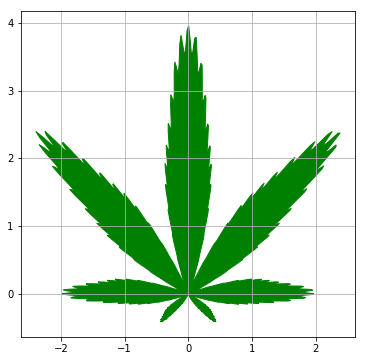

In [37]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

*Clarification update: see task 1.*

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [38]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [39]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    conv_kernel = torch.tensor([[1,1,1],
                                [1,0,1],
                                [1,1,1]], dtype=torch.float32).detach()

    num_alive_neighbors = F.conv2d(alive_map.unsqueeze(0).unsqueeze(0), 
                                   conv_kernel.unsqueeze(0).unsqueeze(0),
                                   padding=1)
    
    num_alive_neighbors.squeeze_(0).squeeze_(0)
    
    born = torch.eq(num_alive_neighbors, 3) & torch.eq(alive_map, 0)  
    survived = (torch.eq(num_alive_neighbors, 3) | torch.eq(num_alive_neighbors, 2)) \
                & torch.eq(alive_map, 1)
    
    alive_map.copy_((born | survived))

In [40]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)
print ((alive_map_torch.numpy() == alive_map_numpy).sum())

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

10000
Well done!


<IPython.core.display.Javascript object>


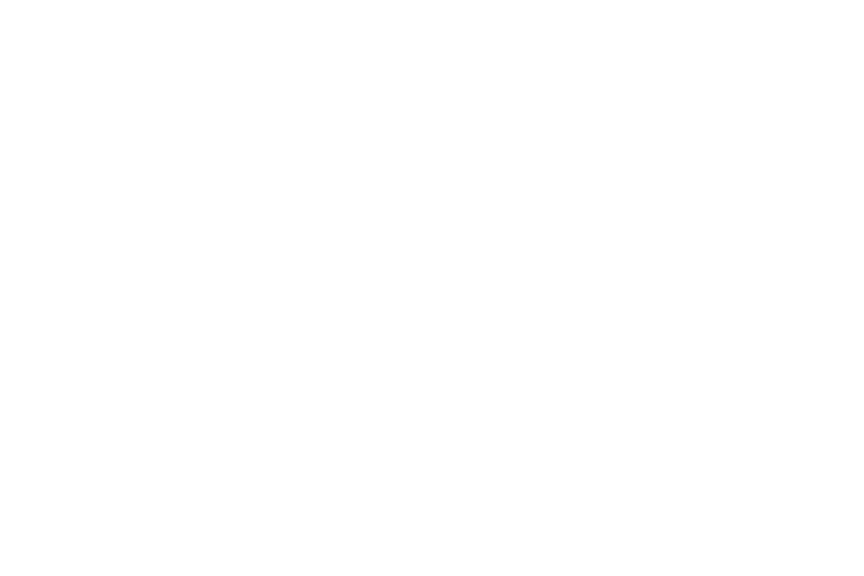

<IPython.core.display.Javascript object>


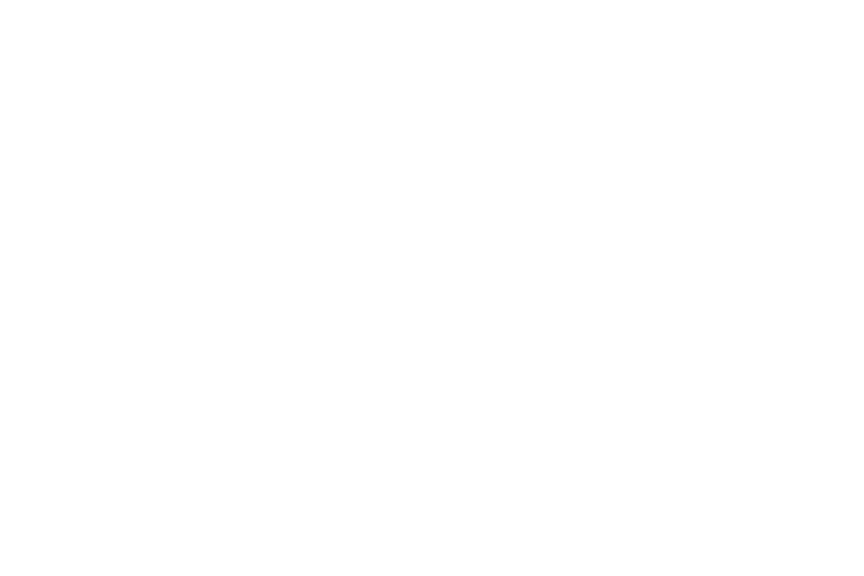

In [41]:
%matplotlib notebook
plt.ion()

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


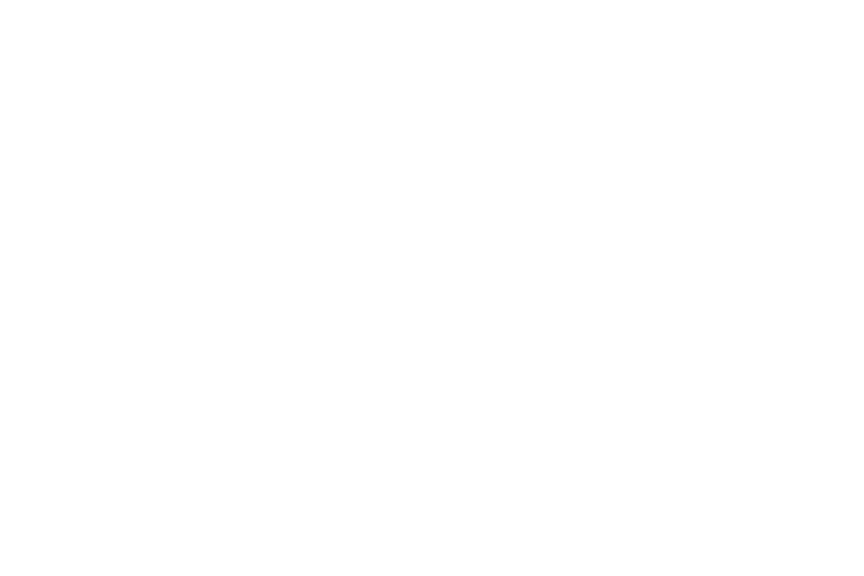

<IPython.core.display.Javascript object>


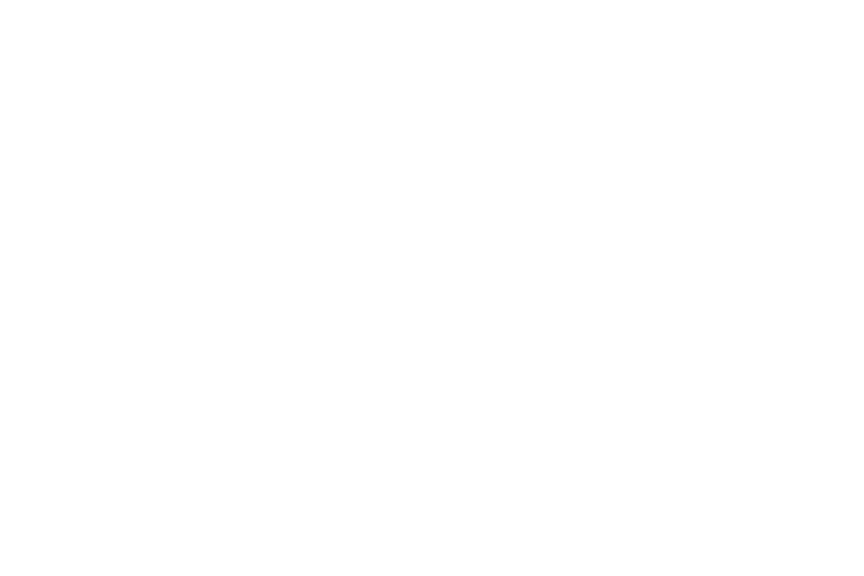

In [9]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`, `torch.utils.data.DataLoader`
* convolutions

##### Clarification update:

1. *you mustn't emulate PyTorch tensors with lists or tuples. Using a list for scaffolding utilities not provided by PyTorch core (e.g. to store model's layers or to group function arguments) is OK;*
2. *you mustn't use numpy or other tensor libraries except PyTorch;*
3. *the purpose of part 1 is to make you google and read the documentation a LOT so that you learn which intrinsics PyTorch provides and what are their interfaces. This is why if there is some tensor functionality that is directly native to PyTorch, you mustn't emulate it with loops. Example:*

```
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

4. *Loops are prohibited except for iterating over*

  * *parameters (and their companion tensors used by optimizer, e.g. running averages),*
  * *layers,*
  * *epochs (or "global" gradient steps if you don't use epoch logic),*
  * *batches in the dataset (using loops for collecting samples into a batch is not allowed).*

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [42]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_()

Parsing...


tensor([[[-0.9453, -0.8372, -0.2884,  ..., -0.2884, -0.8372, -0.9453],
         [-0.8622, -0.7208,  0.0276,  ...,  0.0276, -0.7208, -0.8622],
         [-0.8705, -0.7291,  0.0110,  ...,  0.0110, -0.7291, -0.8705],
         ...,
         [-0.8705, -0.7291,  0.0193,  ...,  0.0193, -0.7291, -0.8705],
         [-0.8705, -0.7291,  0.0193,  ...,  0.0193, -0.7291, -0.8705],
         [-0.8705, -0.7291,  0.0193,  ...,  0.0193, -0.7291, -0.8705]],

        [[-1.1366, -1.1366, -1.1366,  ...,  0.9757,  0.8842,  0.4351],
         [-1.1366, -1.1366, -1.1366,  ..., -0.6127, -0.8123, -1.0118],
         [-1.1366, -1.1366, -1.1366,  ..., -1.1116, -1.1366, -1.1366],
         ...,
         [-1.1366, -1.1366, -1.1283,  ..., -1.1366, -1.1366, -1.1366],
         [-1.0701, -0.9037, -0.7956,  ..., -1.1366, -1.1366, -1.1366],
         [ 0.3769,  0.8260,  0.9008,  ..., -1.1366, -1.1366, -1.1366]],

        [[ 0.1856,  0.7844,  0.7761,  ..., -1.1366, -1.1366, -1.1366],
         [ 0.9840,  0.9840,  0.9840,  ..., -1

<IPython.core.display.Javascript object>


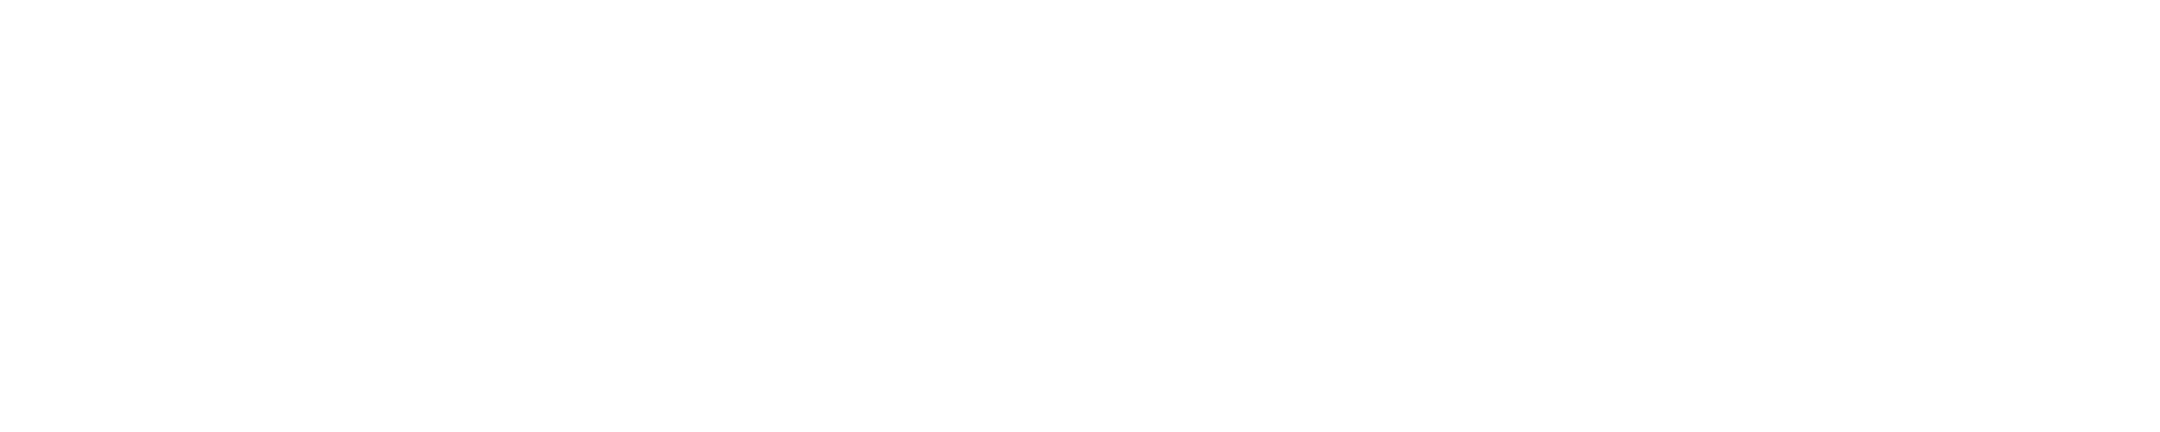

<IPython.core.display.Javascript object>


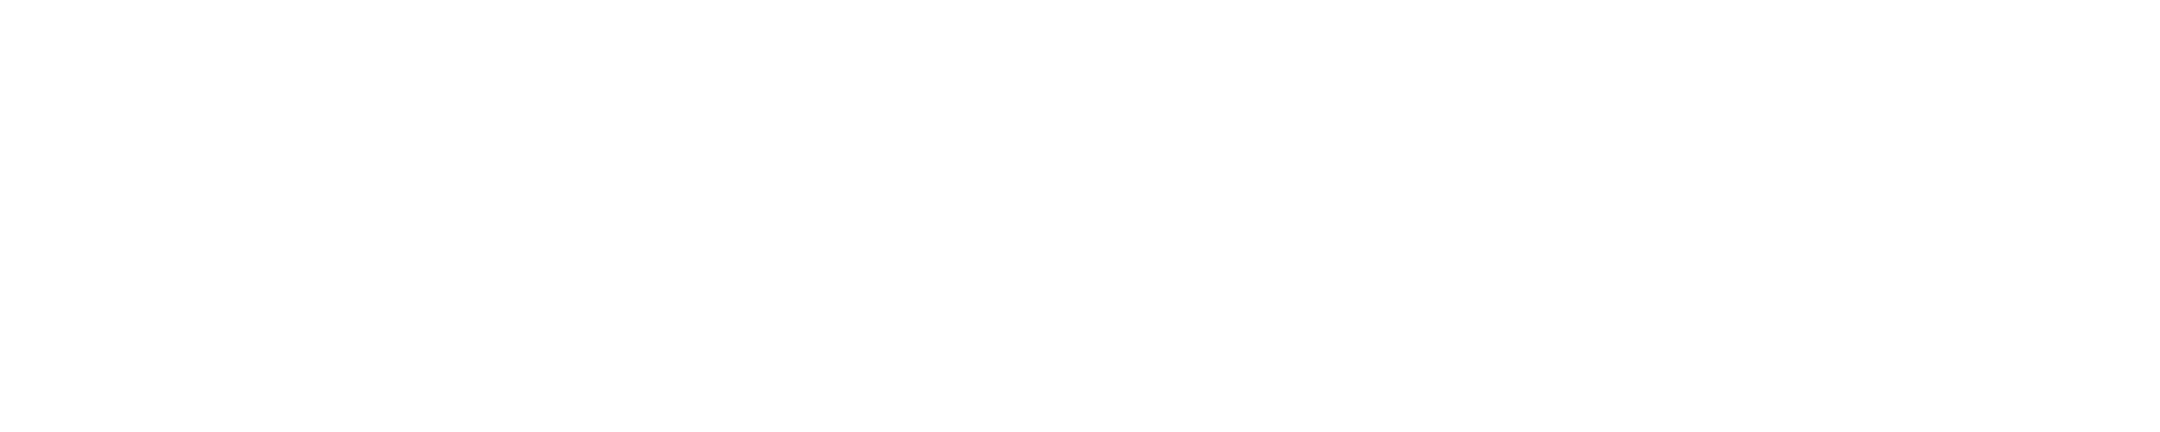

In [43]:
fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [57]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = torch.randperm(n_samples)
    
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]
        
def one_hot_encode(labels, max_label=9):
    labels_one_hot = torch.zeros(labels.shape[0], max_label + 1)
    labels_one_hot[torch.arange(labels.shape[0]), labels] = 1
    
    return labels_one_hot

def one_hot_decode(labels):
    decoded = torch.argmax(labels, -1)#.argmax(axis=-1)
    return decoded

In [58]:
class Linear:
    def __init__(self, n_in, n_out):
        stdv = 1. / math.sqrt(n_in)
        
        self.W = (1 - 2 * torch.rand(n_out, n_in)) * stdv
        self.b = (1 - 2 * torch.rand(n_out)) * stdv
        
        self.W.requires_grad = True
        self.b.requires_grad = True
        
        print (self.W.grad)
        
    def forward(self, input):
        self.output = torch.mm(input, self.W.t()) + self.b
    
        return self.output
    
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.W.grad, self.b.grad]
    
    def zero_grad(self):
        self.W.grad.zero_()
        self.b.grad.zero_()

In [59]:
class LogSoftMax:
    def __init__(self):
        pass
    
    def forward(self, input):
        x_norm = input - torch.max(input, 1, keepdim=True)[0]
        self.output = x_norm - torch.log(torch.sum(torch.exp(x_norm), 1, keepdim=True))
        
        return self.output

In [60]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, input):
        self.output = torch.max(input, torch.zeros_like(input))
        
        return self.output

In [61]:
class NLLCriterion:
    def __init__(self):
        pass
    
    def forward(self, input, target):
        self.output = -1 * torch.sum(target * input) / len(input)
        
        return self.output

In [62]:
class NeuralNet:
    def __init__(self):
        self.linear1 = Linear(784, 128)
        self.relu = ReLU()
        self.linear2 = Linear(128, 10)
        self.logsoftmax = LogSoftMax()
        
    def predict(self, images):
        """
        images: `torch.tensor` of shape `batch_size x height x width`
            and dtype `torch.float32`.
        
        returns: `output`, a `torch.tensor` of shape `batch_size x 10`,
            where `output[i][j]` is the probability of `i`-th
            batch sample to belong to `j`-th class.
        """
        images = images.view(images.shape[0], -1)
        
        # linear #1
        self.l1 = self.linear1.forward(images)
        
        # ReLU
        self.act = self.relu.forward(self.l1)
        
        # linear #2
        self.l2 = self.linear2.forward(self.act)
        
        # log-softmax
        self.lsm = self.logsoftmax.forward(self.l2)

        # NLL
#         x = self.criterion()
        
        return self.lsm
    
    def getParameters(self):
        return self.linear1.getParameters() + self.linear2.getParameters()
    
    def getGradParameters(self):
        return self.linear1.getGradParameters() + self.linear2.getGradParameters()
    
    def zero_grad(self):
        self.linear1.zero_grad()
        self.linear2.zero_grad()

In [63]:
def sgd_momentum(variables, gradients, config, state):
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    with torch.no_grad():
        var_index = 0 
        for current_layer_vars, current_layer_grads in zip(variables, gradients): 
            for current_var, current_grad in zip(current_layer_vars, current_layer_grads):

                old_grad = state['accumulated_grads'].setdefault(var_index, torch.zeros_like(current_grad))


                old_grad = config['momentum'] * old_grad + config['learning_rate'] * current_grad

                current_var -= old_grad
                var_index += 1

class Optimizer(object):
    def __init__(self, optimizer, config):
        self.optimizer_state = {}
        self.optimizer = optimizer
        self.config = config
        
    def step(self, model):
        self.optimizer(model.getParameters(), 
                 model.getGradParameters(), 
                 self.config,
                 self.optimizer_state)

In [64]:
net = NeuralNet()
criterion = NLLCriterion()
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer = Optimizer(sgd_momentum, optimizer_config)
batch_size = 32
train_len = len(X_train) // batch_size + 1 
epochs = 10

None
None


In [65]:
def accuracy_fn(outputs, labels):
    return ((torch.argmax(outputs, -1) == labels).float().mean())

In [66]:
def train(epoch):
    running_loss = 0.
    running_accuracy = 0.
    for batch_idx, data in enumerate(get_batches((X_train, y_train), batch_size)):
        images, labels = data[0].type(torch.FloatTensor), one_hot_encode(data[1])
        labels_decoded = data[1] 
        
        outputs = net.predict(images)
        loss = criterion.forward(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step(net)
        
        net.zero_grad()


    return running_loss / train_len

In [67]:
def accuracy(model, images, labels):
    """
    model: `NeuralNet`
    images: `torch.tensor` of shape `N x height x width`
        and dtype `torch.float32`
    labels: `torch.tensor` of shape `N` and dtype `torch.int64`. Contains
        class index for each sample
    
    returns:
        fraction of samples from `images` correctly classified by `model`
    """
    with torch.no_grad():
        pred = model.predict(images)
        
    
    _, argmax = torch.max(pred, 1)
    return (labels == argmax.squeeze()).float().mean()

In [68]:
X_train.requires_grad = True
for epoch in range(1, epochs + 1):
    print("Epoch:", epoch)
    running_loss = train(epoch)
    print ("Loss :", running_loss)

Epoch: 1
Loss : 0.5488763526082039
Epoch: 2
Loss : 0.15288862690329552
Epoch: 3
Loss : 0.11766148015856742
Epoch: 4
Loss : 0.100870151957497
Epoch: 5
Loss : 0.09050827585160733
Epoch: 6
Loss : 0.08242258589714765
Epoch: 7
Loss : 0.07631953554227948
Epoch: 8
Loss : 0.07111387714743614
Epoch: 9
Loss : 0.06674611577764153
Epoch: 10
Loss : 0.06228160394355655


In [69]:
train_acc = accuracy(net, X_train, y_train) * 100
test_acc = accuracy(net, X_test, y_test) * 100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

Train accuracy: 98.31, test accuracy: 98.12
